# Best model

We tried several Classifiers (KNN, LogisticRegression, ADABoost, RandomForest, see /models folder for notebooks) on the combined dataset and on seperate datasets for cats and dogs. The GradienBoostingClassifier performed best (using a quadratic weighted Kappa score as metric). This notebook contains:
* Baseline model based on EDA findings.
* RandomizedSearch and GridSearch for the best GradientBooster hyperparameters (commented out to reduce notebook runtime)
* Our final model
* Error Analysis and Feature Importance.  

Before we arrived at the parameters for the GridSearch we found a model that was overfit to the train data and we adjusted the GridSearch parameters that are known to cause overfitting: We reduced the maximum number to max_depth, to increased the number of estimators to help the model generalize better and we lowered the learning rate thereby shrinking the contribution of each tree and making the model more robust. This process is not shown here.




In [40]:
# Packages
import pandas as pd
import numpy as np
# plotting
# Modelling
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, cohen_kappa_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# import custom functions
from custom_functions import our_metrics

import pickle

# COMMENTED OUT FOR THIS SYNOPSIS
# mlflow
#import mlflow
#from mlflow.models import infer_signature
#import mlflow.sklearn
#mlflow.set_tracking_uri("http://localhost:5000")

pd.set_option('display.max_rows', 10)


In [9]:
# export processed data set to csv

# export features for tree-based models
X_train_comb = pd.read_csv('./data/petfinder-adoption-prediction/train/X_train_minmax_scaled_processed.csv')
X_test_comb =pd.read_csv('./data/petfinder-adoption-prediction/train/X_test_minmax_scaled_processed.csv')


# export target
y_train_comb = pd.read_csv('./data/petfinder-adoption-prediction/train/y_train.csv')
y_test_comb = pd.read_csv('./data/petfinder-adoption-prediction/train/y_test.csv')

df = pd.read_csv("./data/petfinder-adoption-prediction/eda/df_eda.csv")

# Baseline Model

Create a basic DecisionTree as baseline model. A max_depth of 4 is chosen and the two features age_bin and photo amount which have to be revealed to be important for the adoption speed during our EDA.

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3593
_____________________
Weighted Quadratic Kappa: 0.2219


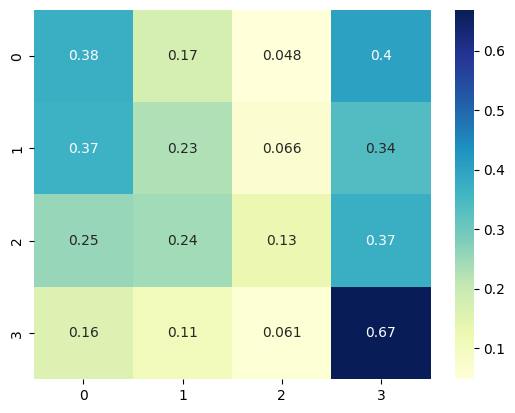

In [12]:
X_baseline = df[["age_bin", "photoamt_11"]]
y = df["adoptionspeed"]
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(X_baseline, y, random_state=42, stratify=y)
baseline = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 15)
baseline.fit(X_train_bl, y_train_bl)

y_pred_bl = baseline.predict(X_test_bl)
our_metrics(y_test_bl, y_pred_bl, normalize=True)

# Gradient Booster
We first did a RandomizedSearch with a tighter range for max_depth, learning rate and number of estimators because otherwise the model will be overfitting too much. Not shown here is the subsequent GridSearch to find the best performing hyperparameters. The RandomizedSearch is commented out because runtime is roughly 10 minutes. 

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4098
_____________________
Weighted Quadratic Kappa: 0.3581


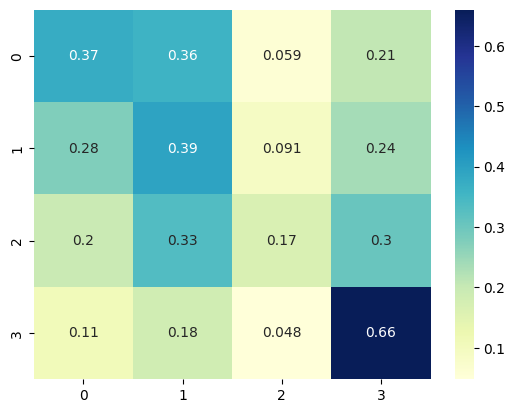

In [35]:
# from sklearn.ensemble import GradientBoostingClassifier
# #
# # with mlflow.start_run(run_name = "GradientBoost_gridsearch_combineddata"):

# gb_classifier = GradientBoostingClassifier(random_state=42)
# param_grid = {
#     'loss': ["log_loss"],
#     'n_estimators': [100, 150, 200, 250, 300],
#     'learning_rate': [0.01 ,0.02, 0.025],
#     'max_leaf_nodes': [20,25,30,35,45],
#     'max_depth': [3,5,7,9],
#     #'l2_regularization': [0,0.25,0.5,0.75,1],
#     'max_features': ['log2'],
#     'subsample': [0.05, 0.25, 0.5, 0.75,1]
#     }

# kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# gbc_tightgrid = RandomizedSearchCV(gb_classifier, param_grid, scoring=kappa_scorer, cv=5, n_jobs=-1,n_iter=100,random_state=42)
# gbc_tightgrid.fit(X_train_comb, y_train_comb.adoptionspeed)

# y_pred_rc = gbc_tightgrid.predict(X_test_comb)
# our_metrics(y_test_comb, y_pred_rc, normalize=True)


# # MLFlow commands 
# #signature = infer_signature(X_test_dogs, y_pred_rc)

# # Log parameter, metrics, and model to MLflow
# # mlflow.log_param("params", gbc_tightgrid.best_params_) # save best_params
# # mlflow.log_metric("acc", accuracy_score(y_test_dogs,y_pred_rc))
# # mlflow.log_metric("kappa", cohen_kappa_score(y_test_dogs,y_pred_rc,weights="quadratic"))
# # mlflow.sklearn.log_model(sk_model = gb_classifier,artifact_path="art", signature=signature,registered_model_name="GradientBoost_gridsearch_combineddata")
# # mlflow.set_tag("data_source", "combined")
# # mlflow.set_tag("experiment_type", "gradient boost")



Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4098
_____________________
Weighted Quadratic Kappa: 0.3581


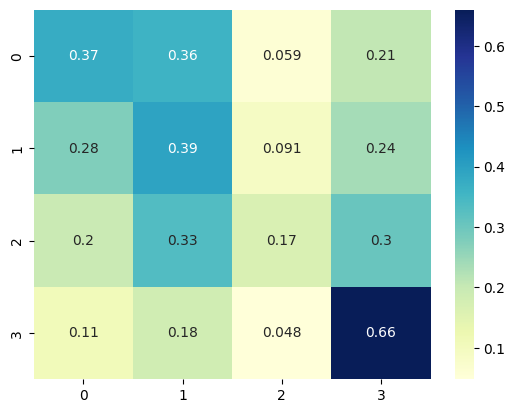

In [37]:
################
# Final model: #
################
gbc = GradientBoostingClassifier(n_estimators=200,subsample=1, max_leaf_nodes=31, max_features='log2', max_depth=5, loss = 'log_loss', learning_rate=0.025, random_state=42)
gbc.fit(X_train_comb, y_train_comb.adoptionspeed)
y_pred_test = gbc.predict(X_test_comb)
y_pred_train = gbc.predict(X_test_comb)
our_metrics(y_test_comb, y_pred_rc, normalize=True)

In [ ]:
# Predict train data to check for excessive overfitting.
y_pred_train = gbc.predict(X_train_comb)
our_metrics(y_train_comb, y_pred_train, normalize=True)

In [42]:
# Serialize the model for streamlit app:
pickle.dump(gbc, open('./streamlit_app/model.sav', 'wb'))

# Error analysis
Here we check the accuracy of predictions for each feature level and see if we find any patterns. Additionally we check if certain feature levels end up in the 3-off category more often.

In [43]:
df_noy = df.drop("adoptionspeed",axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_noy, df["adoptionspeed"], random_state=42, stratify=df["adoptionspeed"]) # We only work with test data so the df is split again into test and train. Manually checked if the order is correct.
df_comb = X_test.reset_index()

#df_comb contains the test data in a non-dummy encoding way.

In [44]:
df_comb["adoptionspeed"] = y_test_comb # Add the correct classes
df_comb["as_pred"] = gbc.predict(X_test_comb) # Add the predictions
df_comb["pred_correct"] = (df_comb["as_pred"] == df_comb["adoptionspeed"]).astype(int) # Check whether the correction is correct (1) or not.
df_comb["overunder_pred"] = df_comb.as_pred - df_comb.adoptionspeed # 0 is a correct prediction. Negative number is an underprediction, positive number is an overprediction.
df_comb["off"] = abs(df_comb["overunder_pred"])
df_comb["desc_bin"] = pd.qcut(df_comb["description_char"],5,labels=[0,1,2,3,4]) # Bin the description length because otherwise the prop_df would contain 1 row for every unique value in description_char

In [45]:
df_comb.groupby("off").describe().loc[:,(slice(None),['count','mean','std'])].T # have a look at the feature level means for the predictions that are correct vs 1 off, 2off, 3off

# The mean for type increases with the 0,1,2,3-off category meaning that cats (type = 1) are more often in the 3-off category.

off                             0            1            2            3
index          count  1185.000000   973.000000   501.000000   233.000000
               mean   5897.257384  5671.036999  6143.746507  5837.227468
               std    3329.494404  3305.066042  3288.197709  3305.874078
type           count  1185.000000   973.000000   501.000000   233.000000
               mean      0.378059     0.402878     0.417166     0.673820
...                           ...          ...          ...          ...
pred_correct   mean      1.000000     0.000000     0.000000     0.000000
               std       0.000000     0.000000     0.000000     0.000000
overunder_pred count  1185.000000   973.000000   501.000000   233.000000
               mean      0.000000     0.025694    -0.131737     0.785408
               std       0.000000     1.000184     1.997651     2.901598

[54 rows x 4 columns]

In [47]:
prop_df = pd.DataFrame(columns=["feature","group","n","n_prop","prop_correct","overunder"])
for cat in ['type', 'gender', 'maturitysize', 'furlength', 'sterilized',
    'health', 'color_pattern', 'breed_type',
    'vaccinated_dewormed', 'fee_bin', 'age_bin', 'desc_bin','photoamt_11']:
    # print(ea_data.groupby(cat)["bank_correct"].mean().reset_index())
    # print("_________")
    test_df = df_comb.groupby(cat)["pred_correct"].mean().reset_index().round(3)                                    # for each categorie level get the mean correct predictions. A value above 0.41 (baseline accuracy) shows that the categorie is predicted below avarage and vice versa.
    test_df.insert(0, "feature", test_df.columns[0])                                                                # add feature name
    test_df["n"] = df_comb.value_counts(cat,sort=False)                                                             # number of observations
    test_df["n_prop"] = round(df_comb.value_counts(cat,sort=False)/len(df_comb),3)                                  # proportion of the above
    test_df["overunder"] = df_comb.groupby(cat)["overunder_pred"].mean().reset_index().overunder_pred.round(3)      # get the mean of over and under predictions for each group. 
    test_df.columns = ["feature","group", "prop_correct","n","n_prop","overunder"]
    test_df[["feature","group","n","n_prop","prop_correct","overunder"]]
    prop_df = pd.concat([prop_df, test_df], axis=0, ignore_index=True)

prop_df.sort_values("prop_correct")
prop_df

# There is a trend that observations with an photoamount of 6-9 pictures are more often missclassified. However, the sample size is not too big and there is no clear bias towards under or overprediction.
# Cats are predicted less accurately compared to dogs.

,feature,group,n,n_prop,prop_correct,overunder
0,type,0,1686,0.583,0.437,0.062
1,type,1,1206,0.417,0.371,0.031
2,gender,0,1292,0.447,0.393,-0.049
3,gender,1,1600,0.553,0.423,0.128
4,maturitysize,0,629,0.217,0.399,-0.297
...,...,...,...,...,...,...
42,photoamt_11,7.0,85,0.029,0.294,-0.082
43,photoamt_11,8.0,46,0.016,0.326,0.261
44,photoamt_11,9.0,35,0.012,0.314,0.114
45,photoamt_11,10.0,50,0.017,0.400,0.160


# Feature importance

In [50]:
pd.DataFrame(gbc.feature_importances_,index=X_train_comb.columns,columns=["feature_importance"]).head(22).sort_values(by="feature_importance")

,feature_importance
health_2,0.004993
maturitysize_3,0.005277
health_1,0.010218
maturitysize_2,0.011453
color_pattern_2,0.011517
...,...
breed_type,0.058305
sterilized,0.080004
photoamt_11,0.153354
description_char,0.181373
